In [1]:
#importing libraries

import pandas as pd
import numpy as np
import math, os, re, random
# --------- for visualization ---------
import matplotlib.pyplot as plt
import seaborn as srn

from sklearn.model_selection import train_test_split
from sklearn.metrics import*
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold



import tensorflow as tf
import tensorflow as tf, tensorflow.keras.backend as K
# --------- for DL model ---------
import tensorflow.keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical


from kaggle_datasets import KaggleDatasets
print('Tensorflow version ' + tf.__version__)



2023-01-14 10:54:09.463098: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-14 10:54:09.463233: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version 2.4.1


In [2]:
AUTO = tf.data.experimental.AUTOTUNE

# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')

IMAGE_SIZE = [192, 192]                   
EPOCHS = 20
BATCH_SIZE = 24 * strategy.num_replicas_in_sync

SEED = 919

GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-192x192'

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

np.set_printoptions(threshold=15, linewidth=80)

# ****** Helper Functions ********

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of images

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset(dataset,do_aug=True):
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if do_aug: dataset = dataset.map(transform, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

# %% [markdown]

# %% [code]
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print("BATCH_SIZE", BATCH_SIZE)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Running on TPU  grpc://10.0.0.2:8470


2023-01-14 10:54:31.982846: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-14 10:54:31.986394: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-14 10:54:31.986439: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-14 10:54:31.986469: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (6b0dbd729cd1): /proc/driver/nvidia/version does not exist
2023-01-14 10:54:31.990133: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


2023-01-14 10:54:37.842301: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-14 10:54:37.919521: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-14 10:54:37.987248: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


BATCH_SIZE 192
Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [4]:
def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

# **Learning Rate Schedule**

Learning rate schedule: 1e-05 to 0.0004 to 1.56e-05


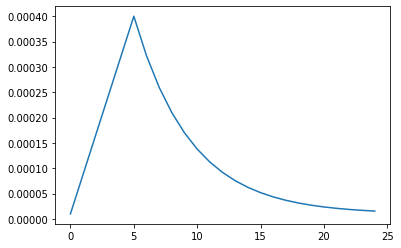

In [5]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))





""""
This code defines a learning rate schedule function that increases the 

learning rate linearly over the first 5 epochs 

(LR_RAMPUP_EPOCHS), maintains it at the maximum value (LR_MAX) for the 

next 0 epochs (LR_SUSTAIN_EPOCHS), and then decreases it

exponentially over the remaining epochs (LR_EXP_DECAY). The maximum

learning rate (LR_MAX) is calculated as a multiple of the number
 
of replicas in sync (strategy.num_replicas_in_sync) and the starting 

learning rate (LR_START) is 0.00001. The minimum learning rate 

(LR_MIN) is 0.00001. The lrfn function takes an epoch number as input

and returns the corresponding learning rate. This function is

then passed as a callback to the LearningRateScheduler function in the

Keras API, along with a verbose parameter to display the 

learning rate at each epoch. Finally, the code plots the learning rate

schedule over the range of total number of epochs and prints 

the initial, maximum and final learning rate values.
""""

# **Data Augmentation**

In [1]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

"""

This code defines a function called get_mat() that takes 
in six parameters: rotation, shear, height_zoom, width_zoom,
height_shift, width_shift. The function converts the rotation
and shear angles from degrees to radians using the math.pi constant
. Then it creates 3x3 matrices for rotation, shear, zoom and shift, by 
using the cosine and sine of the rotation and shear angles, and the 
zoom and shift values. It then returns the dot product of all these
matrices. The rotation matrix is formed by concatenating the cosine
of rotation angle, sine of rotation angle, zero, negative of sine
of rotation angle, cosine of rotation angle, zero and zero, zero and
one. The shear matrix is formed by concatenating one, sine of shear
angle, zero, zero, cosine of shear angle, zero, zero and zero and one.
The zoom matrix is formed by concatenating one/height_zoom, zero, zero,
zero, one/width_zoom, zero, zero, zero and one. The shift matrix is
formed by concatenating one, zero, height_shift, zero, one, width_shift,
zero, zero and one.

""""

SyntaxError: unterminated string literal (detected at line 39) (999580236.py, line 39)

In [7]:
def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label



"""
This code defines a function called transform() that takes in an image and a label as input.
It performs random rotation, shearing, zooming and shifting on the input image, then it maps
the destination pixels of the transformed image back onto the original image.
The code first sets a variable DIM as the size of the image, and XDIM as DIM modulo 2, which
is used later to handle edge cases where DIM is an odd number. Then it generates random values
for rotation, shear, height zoom, width zoom, height shift and width shift using the normal distribution.
Then it calls the get_mat() function with the generated random values for rotation, shear,
height zoom, width zoom, height shift and width shift to get a transformation matrix.
It then creates indices for the destination pixels of the transformed image by repeating
and tiling an array of integers from DIM/2 to -DIM/2, and stack them into a 3D array.
It then applies the transformation matrix to the indices of the destination pixels, which 
rotates them onto the indices of the original pixels. It then clips the indices to avoid out of
bounds errors and finds the values of the original pixels using the indices.
Finally, it reshapes the pixel values to the original image shape and returns the transformed image and the label.



""""


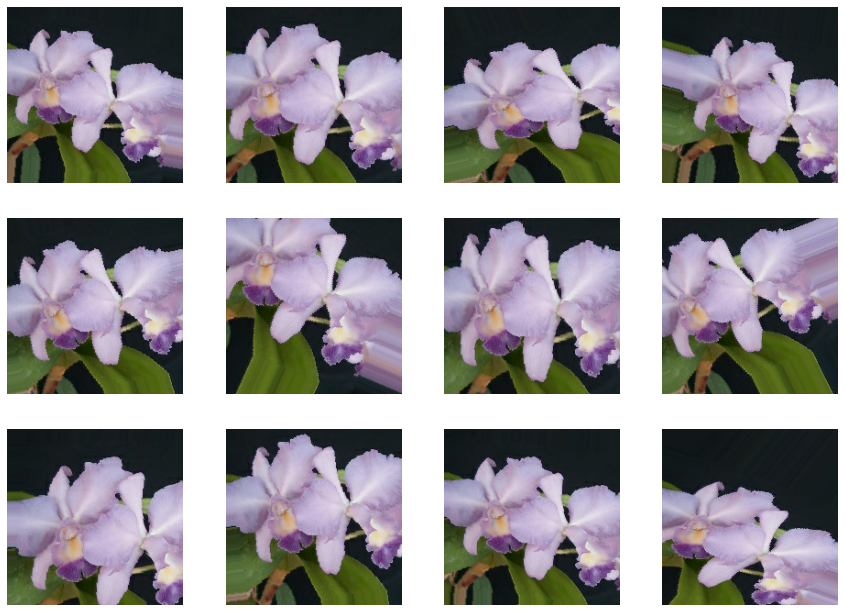

In [8]:
row = 3; col = 4;
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
one_element = tf.data.Dataset.from_tensors( next(iter(all_elements)) )
augmented_element = one_element.repeat().map(transform).batch(row*col)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

# *transfer model*

In [9]:
from tensorflow.keras.applications import DenseNet201

def get_model():
    with strategy.scope():
        
        
        
        
        """
        
        
DenseNet is a type of convolutional neural network (CNN) architecture that was introduced in 2016. It i
        
s designed to address the problem of vanishing gradients in very deep networks by connecting each layer to every other layer in a feed-forward fashion. 
        
This is achieved by introducing a concept called "dense connections" which concatenate the feature maps from all preceding layers as inputs to the current layer.

The DenseNet201 model that is being used in the code you provided is a specific implementation of the DenseNet architecture

that has 201 layers. It is pre-trained on the ImageNet dataset, which means that its weights have already been optimized on a large dataset of images and their corresponding labels, and can be used as a starting point for training on new datasets.

The input shape of the network is defined as (IMAGE_SIZE[0], IMAGE_SIZE[1], 3), which means that the network expects images

of size IMAGE_SIZE with 3 color channels (RGB). The include_top parameter is set to False, which means that the final fully 

connected layer that would normally be used for classification is not included in this implementation of the model.
        
        
        
    
        <<<The DenseNet201 model is a general image classification model that has been pre-trained on the ImageNet dataset >>>>
        
        
        """
        
        
        rnet = DenseNet201(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model



""""

This code defines a function named get_model that returns a TensorFlow Keras model for image classification. The model is built using the

DenseNet201 architecture from the TensorFlow Keras Applications library, which is a pre-trained model on the ImageNet dataset.

The DenseNet201 model is loaded with the input shape of the image, i.e (IMAGE_SIZE[0], IMAGE_SIZE[1], 3), and it's weights are set 

to imagenet. Then the include_top parameter is set to False which means that the final fully connected layer is not included. Then the rnet is set to be trainable.

Then a new sequential model is created and the rnet is added as the first layer, followed by a GlobalAveragePooling2D layer which

is used to reduce the spatial dimensions of the tensor to 1, thus reducing the number of parameters in the model.

Finally, a dense layer with len(CLASSES) number of neurons and activation function as 'softmax' is added as the final layer. The

model is then compiled with 'Adam' optimizer and loss function as 'sparse_categorical_crossentropy' and metrics as 'sparse_categorical_accuracy'

"""


# *train*

In [10]:
def train_cross_validate(folds = 5):
    histories = []
    models = []
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
    kfold = KFold(folds, shuffle = True, random_state = SEED)
    for f, (trn_ind, val_ind) in enumerate(kfold.split(TRAINING_FILENAMES)):
        print(); print('#'*25)
        print('### FOLD',f+1)
        print('#'*25)
        train_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[trn_ind]['TRAINING_FILENAMES']), labeled = True)
        val_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[val_ind]['TRAINING_FILENAMES']), labeled = True, ordered = True)
        model = get_model()
        history = model.fit(
            get_training_dataset(train_dataset), 
            steps_per_epoch = STEPS_PER_EPOCH,
            epochs = EPOCHS,
            callbacks = [lr_callback],#, early_stopping],
            validation_data = get_validation_dataset(val_dataset),
            verbose=2
        )
        models.append(model)
        histories.append(history)
    return histories, models

"""
This function appears to be training and cross-validating a machine learning model using
the KFold method from the scikit-learn library. The function takes a single argument,
"folds", which specifies the number of folds to use for cross-validation. 
The function then initializes some empty lists for storing the training history and
models for each fold. It also sets up an early stopping callback to stop training 
if the validation loss does not improve after a certain number of epochs.
It then splits the training data into "folds" number of partitions using the KFold
method, and for each partition, it loads the training and validation datasets, gets
the model, and trains the model on the training dataset while evaluating on the
validation dataset. It also uses a learning rate schedule callback which will 
adjust the learning rate during training. After training and evaluating the model
on each partition, the function stores the model and its training history in the
corresponding lists, and returns these lists at the end of the function.

""""





In [11]:
histories, models = train_cross_validate(folds = 5)


#########################
### FOLD 1
#########################
74842112/74836368 [==============================] - 0s 0us/step
Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
66/66 - 172s - loss: 4.3993 - sparse_categorical_accuracy: 0.0879 - val_loss: 4.0928 - val_sparse_categorical_accuracy: 0.1548


2023-01-14 10:59:08.476696: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 84526, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1673693948.473377165","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 84526, Output num: 0","grpc_status":3}


Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
66/66 - 11s - loss: 2.1222 - sparse_categorical_accuracy: 0.5437 - val_loss: 1.4355 - val_sparse_categorical_accuracy: 0.6657
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
66/66 - 11s - loss: 0.7850 - sparse_categorical_accuracy: 0.8325 - val_loss: 0.7530 - val_sparse_categorical_accuracy: 0.8192
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
66/66 - 11s - loss: 0.3962 - sparse_categorical_accuracy: 0.9115 - val_loss: 0.6015 - val_sparse_categorical_accuracy: 0.8618
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
66/66 - 11s - loss: 0.2281 - sparse_categorical_accuracy: 0.9489 - val_loss: 0.6791 - val_sparse_categorical_accuracy: 0.8283
Epoch 6/20

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004.
66/66 - 11s - loss: 0.1732 - sparse_categorical_accuracy: 0.9594 - val_loss: 0.6569 

2023-01-14 11:06:10.107380: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 181204, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1673694370.107307822","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 181204, Output num: 0","grpc_status":3}


Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
66/66 - 11s - loss: 2.1544 - sparse_categorical_accuracy: 0.5439 - val_loss: 1.3234 - val_sparse_categorical_accuracy: 0.6856
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
66/66 - 11s - loss: 0.8125 - sparse_categorical_accuracy: 0.8179 - val_loss: 0.6863 - val_sparse_categorical_accuracy: 0.8411
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
66/66 - 11s - loss: 0.4119 - sparse_categorical_accuracy: 0.9093 - val_loss: 0.6299 - val_sparse_categorical_accuracy: 0.8487
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
66/66 - 11s - loss: 0.2640 - sparse_categorical_accuracy: 0.9377 - val_loss: 0.5781 - val_sparse_categorical_accuracy: 0.8617
Epoch 6/20

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004.
66/66 - 11s - loss: 0.1932 - sparse_categorical_accuracy: 0.9530 - val_loss: 0.5643 

2023-01-14 11:13:22.579780: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 277806, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1673694802.579615813","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 277806, Output num: 0","grpc_status":3}


Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
66/66 - 11s - loss: 2.1814 - sparse_categorical_accuracy: 0.5316 - val_loss: 1.3176 - val_sparse_categorical_accuracy: 0.6951
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
66/66 - 11s - loss: 0.8080 - sparse_categorical_accuracy: 0.8201 - val_loss: 0.7237 - val_sparse_categorical_accuracy: 0.8183
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
66/66 - 11s - loss: 0.4166 - sparse_categorical_accuracy: 0.9055 - val_loss: 0.5630 - val_sparse_categorical_accuracy: 0.8655
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
66/66 - 11s - loss: 0.2648 - sparse_categorical_accuracy: 0.9391 - val_loss: 0.5571 - val_sparse_categorical_accuracy: 0.8605
Epoch 6/20

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004.
66/66 - 11s - loss: 0.1845 - sparse_categorical_accuracy: 0.9562 - val_loss: 0.6138 

2023-01-14 11:20:39.121014: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 374408, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1673695239.120667588","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 374408, Output num: 1","grpc_status":3}


Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
66/66 - 11s - loss: 2.1336 - sparse_categorical_accuracy: 0.5401 - val_loss: 1.3639 - val_sparse_categorical_accuracy: 0.6675
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
66/66 - 11s - loss: 0.7958 - sparse_categorical_accuracy: 0.8254 - val_loss: 0.6593 - val_sparse_categorical_accuracy: 0.8421
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
66/66 - 11s - loss: 0.4130 - sparse_categorical_accuracy: 0.9092 - val_loss: 0.5447 - val_sparse_categorical_accuracy: 0.8634
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
66/66 - 11s - loss: 0.2640 - sparse_categorical_accuracy: 0.9395 - val_loss: 0.5064 - val_sparse_categorical_accuracy: 0.8755
Epoch 6/20

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004.
66/66 - 11s - loss: 0.1939 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.6225 

2023-01-14 11:27:42.778788: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 471010, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1673695662.778683498","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 471010, Output num: 0","grpc_status":3}


Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
66/66 - 11s - loss: 2.1279 - sparse_categorical_accuracy: 0.5492 - val_loss: 1.3028 - val_sparse_categorical_accuracy: 0.7059
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
66/66 - 11s - loss: 0.7866 - sparse_categorical_accuracy: 0.8273 - val_loss: 0.6879 - val_sparse_categorical_accuracy: 0.8475
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
66/66 - 11s - loss: 0.3936 - sparse_categorical_accuracy: 0.9149 - val_loss: 0.5369 - val_sparse_categorical_accuracy: 0.8718
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
66/66 - 11s - loss: 0.2516 - sparse_categorical_accuracy: 0.9418 - val_loss: 0.5639 - val_sparse_categorical_accuracy: 0.8609
Epoch 6/20

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004.
66/66 - 11s - loss: 0.1885 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.5431 

# *test and predict*

In [12]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.
test_images_ds = test_ds.map(lambda image, idnum: image)
print('Computing predictions...')
# get the mean probability of the folds models
probabilities = np.average([models[i].predict(test_images_ds) for i in range(5)], axis = 0)
predictions = np.argmax(probabilities, axis=-1)
print('Generating submission.csv file...')

""""
This code appears to be generating predictions for a test dataset using a

ensemble of trained models. The first line calls a 

function "get_test_dataset" which returns a dataset of test images, and it

is specified that the order of the images should be maintained. The next

line maps the test dataset to only include the images, and discards the associated labels/ids.

Then, the code prints that it is computing predictions and then it uses a 

list comprehension to generate predictions for each model in the list of models

"models" with length 5. These predictions are stored in a numpy array "probabilities"

with the average of the predictions computed across all 5 models.

The next line, the code generates a numpy array 'predictions' by taking the argmax

of the probabilities array along the last axis.

Finally, the code prints that it is generating a submission.csv file

which probably is a file that contains the predictions in a format 

that can be submitted to an evaluation system.

"""





Computing predictions...


2023-01-14 11:32:03.816174: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 483703, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1673695923.816102212","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 483703, Output num: 0","grpc_status":3}
2023-01-14 11:33:08.024688: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 484370, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task

Generating submission.csv file...


In [13]:
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
print(NUM_TEST_IMAGES)
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
print(predictions[0])
print(test_ids[0])
print("------------------")


np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%s'], delimiter=',', header='id,label', comments='')

# Look at the first few predictions
!head submission.csv

""""
This code is preparing the test image ids for the final submission file. 

The first line maps the test dataset to only include the ids of the images 

and discard the images. The next line discards the batches of the ids dataset.

It then prints the number of test images and prints the first test id and the first prediction.

The next line uses the numpy function savetxt to save the test_ids and

predictions as a csv file named 'submission.csv'. The first column of 

this file will be the test_ids and the second column will be the predictions.

The function is also specifying the format of the columns (strings), 

the delimiter (comma) and the header of the csv file.

The last line of the code is using shell command 'head' which prints 

the first few lines of the submission.csv file, so that the user can 

check the format of the file and the first predictions


"""



7382
67
252d840db
------------------
id,label
252d840db,67
1c4736dea,28
c37a6f3e9,83
00e4f514e,103
59d1b6146,46
8d808a07b,53
aeb67eefb,52
53cfc6586,29
aaa580243,82


In [14]:
def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset


"""

This function appears to be preparing a validation dataset for machine learning model evaluation. 

The function takes a single argument "ordered" which specifies whether the order of the images 

in the dataset should be maintained or not.

The first line of the function calls a function "load_dataset" which loads the validation dataset

from a list of filenames "VALIDATION_FILENAMES" into memory and it is specified that these images should be labeled and the order of the images should be maintained if ordered is set to true.

The next line of the function batched the loaded dataset into batches of size "BATCH_SIZE".

The next line of the function caches the dataset in memory so that it can be accessed faster in the future.

Finally, the last line of the function prefetch the dataset so that it can be loaded in parallel 

while the model is being trained. The function then returns the prepared dataset.

"""

In [16]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)




"""
This code appears to be modifying the validation dataset 

that was previously loaded and prepared in the "get_validation_dataset" function.

The first line calls the get_validation_dataset() function

to get the validation dataset.

The next line unbatch the validation dataset.

The next line batch the validation dataset again with a batch size of 20.

Finally, it creates an iterator 'batch' on the validation dataset, so that 

the data can be accessed and processed in batch of size 20.


"""

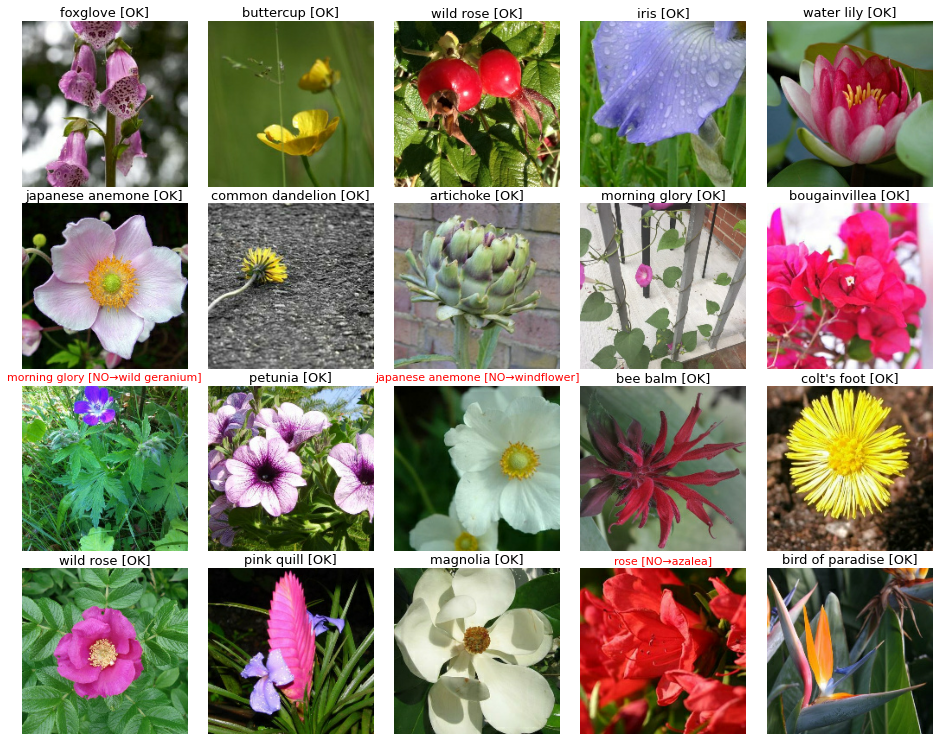

In [23]:
images, labels = next(batch)
probabilities = models[0].predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)



"""
This code appears to be using the batch of validation images and labels generated 

by the iterator 'batch' to evaluate the performance of a trained model.

The first line uses the iterator 'batch' to get the next batch of images and labels.

The next line uses the predict function of the first model in the list of models

"models" to generate predictions for the batch of images. The output of this function

is an array of probabilities,

where each element corresponds to the probability of the image belonging to each class.

The next line uses numpy's argmax function to generate class predictions from 

the probability array. The argmax function returns the index of the maximum element along a given axis, so in this case, it returns the class with the highest predicted probability for each image in the batch.

The last line uses a function "display_batch_of_images" to display the original 

images, the actual labels, and the predicted labels for the batch of validation images. 

This can help to visually inspect the predictions and evaluate the performance of the model.


"""